In [1]:
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

# Loading the data

In [2]:
api = wandb.Api(timeout=30)

entity = "mosaic-ml"
project = "rebuttal-mlm-schedule"

min_perf = 0.3

In [3]:
task_to_metric = {
    "cola": "metrics/glue_cola/MulticlassMatthewsCorrCoef",
    "mnli": ["metrics/glue_mnli/MulticlassAccuracy", "metrics/glue_mnli_mismatched/MulticlassAccuracy"],
    "mrpc": ["metrics/glue_mrpc/BinaryF1Score", "metrics/glue_mrpc/MulticlassAccuracy"],
    "qnli": "metrics/glue_qnli/MulticlassAccuracy",
    "qqp": ["metrics/glue_qqp/BinaryF1Score", "metrics/glue_qqp/MulticlassAccuracy"],
    "rte": "metrics/glue_rte/MulticlassAccuracy",
    "sst-2": "metrics/glue_sst2/MulticlassAccuracy",
    "stsb": "metrics/glue_stsb/SpearmanCorrCoef"
}
tasks = [
    'mnli',
    'qnli',
    'qqp',
    'cola',
    'sst-2',
    'rte',
    'mrpc',
    'stsb',
]
tasks_formatted = [
    "cola/MulticlassMatthewsCorrCoef",
    "mnli/MulticlassAccuracy",
    "mnli_mismatched/MulticlassAccuracy",
    "mrpc/BinaryF1Score",
    "mrpc/MulticlassAccuracy",
    "qnli/MulticlassAccuracy",
    "qqp/BinaryF1Score",
    "qqp/MulticlassAccuracy",
    "rte/MulticlassAccuracy",
    "sst2/MulticlassAccuracy",
    "stsb/SpearmanCorrCoef"
]

In [4]:
min_task_acc = {
    "cola/MulticlassMatthewsCorrCoef": 45,
    "mnli/MulticlassAccuracy": 75,
    "mnli_mismatched/MulticlassAccuracy": 75,
    "mrpc/BinaryF1Score": 82,
    "mrpc/MulticlassAccuracy": 75,
    "qnli/MulticlassAccuracy": 80,
    "qqp/BinaryF1Score": 75,
    "qqp/MulticlassAccuracy": 80,
    "rte/MulticlassAccuracy": 65,
    "sst2/MulticlassAccuracy": 80,
    "stsb/SpearmanCorrCoef": 75,
}

In [26]:
def get_runs(skip_ids=[]):
    run_lookup = {}
    runs = api.runs("mosaic-ml/rebuttal-mlm-schedule", filters={
        "$and": [{'tags': "bert-base"}, {"tags": "glue"}]})
    for run in tqdm(runs):
        if run.state != "finished":
            continue
        
        if run.id in skip_ids:
            continue

        run_name = run.name
        task = [s for s in run_name.split("_") if "task=" in s][0].split("=")[1]
        if re.search(r"ckpt-(\d+)", run_name) is None:
               print(run_name)
        ckpt = int(re.search(r"ckpt-(\d+)", run_name).group(1))
        tags = run.tags
        group = run.group
        experiment_name = group.split("-seed-")[0]
        scheduler = experiment_name.split("-")[2]
        init_rate = [float(t.split("-")[1]) for t in tags if "initial" in t][0]
        final_rate = [float(t.split("-")[1]) for t in tags if "final" in t][0]
        experiment_name = f"{scheduler}-{init_rate}-{final_rate}"
        pretrain_seed = int(re.search(r"seed-(\d+)", group).group(1))
        glue_seed = int(re.search(r"seed=(\d+)", run_name).group(1))
            
                
        if task == 'sst2':
            task = 'sst-2'
        
        if task not in tasks:
            raise ValueError(f"Task {task} not recognized.")
        
        try:
            metric_names = task_to_metric[task]
            if isinstance(metric_names, str):
                metric_names = [metric_names]
            elif not isinstance(metric_names, list):
                raise Exception("Unsupported type for 'metric_name'")

            for metric_idx, metric_name in enumerate(metric_names):
                metric_hist = run.history(keys=[metric_name]).to_numpy()[:, 1:].mean(axis=1)
                final_metric = max(metric_hist)
                
                # if final_metric < min_perf:
                #     continue
                
                metric_task = metric_name.replace("metrics/glue_", "")
                run_lookup[run.id + f"-{metric_idx}"] = {
                    'task': metric_task,
                    'experiment_name': experiment_name,
                    'final_metric': 100 * final_metric,
                    'pretrain_seed': pretrain_seed,
                    "glue_seed": glue_seed,
                    "ckpt": ckpt,
                    'scheduler': scheduler,
                    "init_rate": init_rate,
                    "final_rate": final_rate
                }
        except Exception as e:
            print(f"Error for run: {group} with id ({run.id})")
            print(e)
                
    return run_lookup

In [27]:
def save_runs(save_name, runs):
    with open(save_name, 'wb') as f:
        pickle.dump(runs, f)

def load_runs(save_name):
    with open(save_name, 'rb') as f:
        runs = pickle.load(f)
    return runs

In [28]:
load_path = "rts-glue/speedup-bert-base-results.pkl"
save_path = "rts-glue/speedup-bert-base-results.pkl"

# old_run_ids = set(load_runs(load_path).keys())
old_run_ids = set()

run_lookup = get_runs(skip_ids=old_run_ids)

save_runs(save_path, run_lookup)

100%|██████████| 720/720 [02:15<00:00,  5.31it/s]


In [29]:
load_path = "rts-glue/speedup-bert-base-results.pkl"

In [30]:
run_lookup = load_runs(load_path)

In [31]:
columns=["task", "experiment_name", "final_metric", "pretrain_seed",
         "glue_seed", "ckpt", "scheduler", "init_rate", "final_rate"]
results = []
for run_info in run_lookup.values():
    if run_info is None:
        continue
    if run_info["ckpt"] >=60_000 and run_info["final_metric"] < min_task_acc[run_info["task"]]:
        continue
    run_data = [run_info[c] for c in columns]
    # for c in columns:
    #     if c == "experiment_name":
    #         run_data.append(run_info[c] + f"-ckpt-{run_info['ckpt']}")
    #     else:
    #         run_data.append(run_info[c])
    results.append(run_data)
base_df = pd.DataFrame(results, columns = columns)
base_df = base_df.rename(columns={"ckpt": "steps"})
base_df[["final_metric", 'pretrain_seed', "glue_seed", "steps", "init_rate", "final_rate"]] = base_df[["final_metric", 'pretrain_seed', "glue_seed", "steps", "init_rate", "final_rate"]].apply(pd.to_numeric)
base_df = base_df.sort_values(by=['experiment_name'], ascending=False)

base_df

,task,experiment_name,final_metric,pretrain_seed,glue_seed,steps,scheduler,init_rate,final_rate
607,mnli_mismatched/MulticlassAccuracy,linear-0.3-0.15,83.543533,3047,8364,60000,linear,0.30,0.15
783,mnli_mismatched/MulticlassAccuracy,linear-0.3-0.15,83.513021,42,10536,70000,linear,0.30,0.15
541,mnli_mismatched/MulticlassAccuracy,linear-0.3-0.15,83.329946,42,90166,50000,linear,0.30,0.15
542,mnli/MulticlassAccuracy,linear-0.3-0.15,83.352011,3047,10536,50000,linear,0.30,0.15
543,mnli_mismatched/MulticlassAccuracy,linear-0.3-0.15,83.594388,3047,10536,50000,linear,0.30,0.15
...,...,...,...,...,...,...,...,...,...
358,qqp/BinaryF1Score,constant-0.15-0.15,88.105637,42,10536,50000,constant,0.15,0.15
357,qqp/MulticlassAccuracy,constant-0.15-0.15,91.224337,42,90166,50000,constant,0.15,0.15
356,qqp/BinaryF1Score,constant-0.15-0.15,88.158244,42,90166,50000,constant,0.15,0.15
354,sst2/MulticlassAccuracy,constant-0.15-0.15,91.743118,42,19,50000,constant,0.15,0.15


# Sanity check data

In [32]:
for task in tasks_formatted:
    print(task)
    print(base_df[base_df.task==task].experiment_name.value_counts())
    print(' ')

cola/MulticlassMatthewsCorrCoef
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
mnli/MulticlassAccuracy
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
mnli_mismatched/MulticlassAccuracy
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
mrpc/BinaryF1Score
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
mrpc/MulticlassAccuracy
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
qnli/MulticlassAccuracy
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    30
Name: count, dtype: int64
 
qqp/BinaryF1Score
experiment_name
linear-0.3-0.15       30
constant-0.3-0.3      30
constant-0.15-0.15    29
Name: count, dtype:

In [33]:
# base_df = base_df[base_df["glue_seed"] != 8364]
# base_df = base_df[base_df["pretrain_seed"] != 2048]

In [34]:
metric_stand_err = base_df.groupby(["experiment_name", "task", "steps"])["final_metric"].sem().reset_index()
metric_stand_err
grouped_df = base_df.groupby(["experiment_name", "task", "steps"]).mean(numeric_only=True).reset_index()
grouped_df["error"] = metric_stand_err["final_metric"]
grouped_df = grouped_df.round({'final_metric': 2, 'error': 2})
grouped_df

,experiment_name,task,steps,final_metric,pretrain_seed,glue_seed,init_rate,final_rate,error
0,constant-0.15-0.15,cola/MulticlassMatthewsCorrCoef,50000,56.30,1544.5,21960.4,0.15,0.15,0.41
1,constant-0.15-0.15,cola/MulticlassMatthewsCorrCoef,60000,57.03,1544.5,21960.4,0.15,0.15,0.38
2,constant-0.15-0.15,cola/MulticlassMatthewsCorrCoef,70000,57.80,1544.5,21960.4,0.15,0.15,0.54
3,constant-0.15-0.15,mnli/MulticlassAccuracy,50000,82.82,1544.5,21960.4,0.15,0.15,0.06
4,constant-0.15-0.15,mnli/MulticlassAccuracy,60000,83.03,1544.5,21960.4,0.15,0.15,0.10
...,...,...,...,...,...,...,...,...,...
94,linear-0.3-0.15,sst2/MulticlassAccuracy,60000,91.94,1544.5,21960.4,0.30,0.15,0.10
95,linear-0.3-0.15,sst2/MulticlassAccuracy,70000,91.86,1544.5,21960.4,0.30,0.15,0.14
96,linear-0.3-0.15,stsb/SpearmanCorrCoef,50000,89.68,1544.5,21960.4,0.30,0.15,0.10
97,linear-0.3-0.15,stsb/SpearmanCorrCoef,60000,90.14,1544.5,21960.4,0.30,0.15,0.09


In [35]:
metrics_with_errors = []
for task_name in tasks_formatted:
    metrics_with_errors.append(task_name)
    metrics_with_errors.append(task_name + " STE")
metrics_with_errors

['cola/MulticlassMatthewsCorrCoef',
 'cola/MulticlassMatthewsCorrCoef STE',
 'mnli/MulticlassAccuracy',
 'mnli/MulticlassAccuracy STE',
 'mnli_mismatched/MulticlassAccuracy',
 'mnli_mismatched/MulticlassAccuracy STE',
 'mrpc/BinaryF1Score',
 'mrpc/BinaryF1Score STE',
 'mrpc/MulticlassAccuracy',
 'mrpc/MulticlassAccuracy STE',
 'qnli/MulticlassAccuracy',
 'qnli/MulticlassAccuracy STE',
 'qqp/BinaryF1Score',
 'qqp/BinaryF1Score STE',
 'qqp/MulticlassAccuracy',
 'qqp/MulticlassAccuracy STE',
 'rte/MulticlassAccuracy',
 'rte/MulticlassAccuracy STE',
 'sst2/MulticlassAccuracy',
 'sst2/MulticlassAccuracy STE',
 'stsb/SpearmanCorrCoef',
 'stsb/SpearmanCorrCoef STE']

# Plotting speedups

In [36]:
from scipy.optimize import curve_fit

def func_family(t, c1, c2, c3, c4):
  return c1 - c2 * np.exp(-(1.0 * c3 * t)**c4)

curves = {}
  
def solve_for_y(y, coefs):
  c1, c2, c3, c4 = coefs
  wct = (y - c1) / -c2
  wct = (-1 * np.log(wct)) ** (1.0 / c4)
  wct = wct / c3
  return wct

In [37]:
paper_just_metrics = ["mnli/MulticlassAccuracy", "mnli_mismatched/MulticlassAccuracy", "qnli/MulticlassAccuracy",
                 "qqp/BinaryF1Score", "rte/MulticlassAccuracy", "sst2/MulticlassAccuracy",
                 "mrpc/BinaryF1Score", "cola/MulticlassMatthewsCorrCoef", "stsb/SpearmanCorrCoef"
                ]

In [38]:
def plot_speedup_curves(
    filt_time_df,
    baseline_run_name='constant-0.15-0.15',
    plot_as_steps=False,
    tasks=None,
    exclude_tasks=None,
    experiments=None,
    exclude_experiments=None,
    ax=None,
    ylim=None,
    show_full_baseline=False,
):
  assert (tasks is None) or (exclude_tasks is None)
  assert (experiments is None) or (exclude_experiments is None)

  if tasks is None:
    tasks = set(filt_time_df.task.unique())
  else:
    tasks = set(tasks)
  if exclude_tasks:
    for task in exclude_tasks:
      if task not in tasks:
        raise ValueError(f'{task} (found in `exclude_tasks`) is not a valid task name.')
      tasks.remove(task)
  avg_tasks = sorted(list(tasks))
  filt_time_df = filt_time_df[["experiment_name", "task", "steps", "final_metric"]]

  keep = [x in avg_tasks for x in filt_time_df.task.to_list()]
  grouped_time_df = filt_time_df[keep].groupby(
      ["experiment_name", "task", 'steps']).mean().reset_index()
  glue_df = grouped_time_df.groupby(["experiment_name", "steps"]).mean(numeric_only=True).reset_index()

  # Finally, filter any timesteps where not all tasks have numbers
  # keep = []
  # for exp, s in zip(glue_df.experiment_name.to_list(), glue_df.steps.to_list()):
  #   exp_match = (grouped_time_df.experiment_name==exp)
  #   steps_match = (grouped_time_df.steps==s)
  #   keep.append(
  #       avg_tasks == sorted(grouped_time_df[exp_match & steps_match].task.to_list())
  #   )
  # glue_df = glue_df[keep]
  if experiments is None:
    experiments = set(glue_df.experiment_name.unique())
    if baseline_run_name not in experiments:
      raise ValueError(f'Baseline experiment name "{baseline_run_name}" is not a valid experiment name.')
  else:
    experiments = set(experiments)
  experiments.add(baseline_run_name)
  experiments.remove(baseline_run_name)
  if exclude_experiments:
    for experiment in exclude_experiments:
      if experiment == baseline_run_name:
        raise ValueError(f'Cannot exclude the baseline experiment "{baseline_run_name}"')
      if experiment in experiments:
        experiments.remove(experiment)
      # else:
      #   raise ValueError(f'{experiment} (found in `exclude_experiments`) is not a valid experiment name.')
  experiments = sorted(list(experiments))
  print(grouped_time_df[(grouped_time_df.experiment_name=="linear-0.3-0.15") & (grouped_time_df.steps == 70_000)])
  print(glue_df[(glue_df.experiment_name=="linear-0.3-0.15") & (glue_df.steps == 70_000)])
  mcn = max([len(exp) for exp in experiments])+1

  # if ax is None:
  #   fig = plt.figure(figsize=(10, 7), dpi=100)
  #   fig.patch.set_alpha(1.0)
  #   ax = fig.gca()

  subset = glue_df[glue_df.experiment_name==baseline_run_name]
  x = np.array(subset.wct) if not plot_as_steps else None
  y = np.array(subset["final_metric"])
  s = np.array(subset.steps)
  x = s if plot_as_steps else x
  print(x, "x")
  coefs, _ = curve_fit(
      func_family, x, y,
      p0=[max(y), min(y), 1/10000, 1],
      bounds=[(0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)],
      maxfev=10000
  )
  FINAL_STEP_COUNT = glue_df[(glue_df.experiment_name==baseline_run_name)]['steps'].max()
  baseline_df = glue_df[(glue_df.experiment_name==baseline_run_name) & (glue_df.steps==FINAL_STEP_COUNT)]
  baseline_wct = baseline_df.steps.mean() if plot_as_steps else baseline_df.wct.mean()
  # To deal with noise, we're projecting trends based on fits.
  # We should do the same for the baseline. Hence, we use the *predicted* metric
  # given the fit at the final step (as opposed to the raw data at that point).
  baseline_metric = func_family(baseline_wct, *coefs)
  # if show_full_baseline:
  #   line = ax.plot(x, y, '.', markersize=15, label=baseline_run_name);
  #   color = color=line[0].get_color()
  #   # iso_wct = solve_for_y(baseline_metric, coefs)
  #   xfit = np.linspace(x[0], x[-1], 100)
  #   # ax.plot(xfit, func_family(xfit, *coefs), '-', color=color);
  # else:
    # ax.plot(baseline_wct, baseline_metric, 'x', label=baseline_run_name, markersize=15)

  coefs = {}
  speed_ups = {}
  for experiment_name in experiments + [baseline_run_name]:
    speedup_result = {}
    subset = glue_df[glue_df.experiment_name==experiment_name]
    x = np.array(subset.wct) if not plot_as_steps else None
    y = np.array(subset["final_metric"])
    s = np.array(subset.steps)
    x = s if plot_as_steps else x
    # print(experiment_name)
    # print(y)
    # line = ax.plot(x, y, '.', label=experiment_name, markersize=15);
    coefs[experiment_name], _ = curve_fit(
        func_family, x, y,
        p0=[max(y), min(y), 1/10000, 1],
        bounds=[(0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)],
        maxfev=10000
    )
    iso_wct = solve_for_y(baseline_metric, coefs[experiment_name])

    speedup_result['x'] = x
    speedup_result['y'] = y
    speedup_result['coefs'] = coefs[experiment_name]
    speed_ups[experiment_name] = speedup_result
    # iso_wct = solve_for_y(84.12, coefs[experiment_name])
    xfit = np.linspace(x[0], x[-1], 100)
    # ax.plot(xfit, func_family(xfit, *coefs[experiment_name]), '-', color=line[0].get_color());
    estr = f"{experiment_name:<200}"[:mcn]
    if plot_as_steps:
      print(f"{estr}: {baseline_metric:.3f} in {(np.round(iso_wct)):6.0f} steps; Speedup = {baseline_wct / iso_wct:.2f}x")
    else:
      print(f"{estr}: {baseline_metric:.3f} in {(iso_wct/3600):4.1f}h; Speedup = {baseline_wct / iso_wct:.2f}x")

  ############
  # ax.legend(loc='lower right')
  # ax.set_xlabel("Pre-Training Steps" if plot_as_steps else "Wall Clock Time (s)")
  # ax.set_ylabel(f"Avg Metric(s) for: {', '.join(avg_tasks)}")
  # ax.grid(b=True)
  # if ylim is not None:
  #   ax.set_ylim(ylim)

  return speed_ups

In [51]:
speedup_results = plot_speedup_curves(filt_time_df=grouped_df, plot_as_steps=True, show_full_baseline=True, baseline_run_name="constant-0.3-0.3",
                    experiments=["constant-0.15-0.15", "constant-0.3-0.3", "linear-0.3-0.15"], tasks=paper_just_metrics)

    experiment_name                                task  steps  final_metric
56  linear-0.3-0.15     cola/MulticlassMatthewsCorrCoef  70000         58.02
59  linear-0.3-0.15             mnli/MulticlassAccuracy  70000         83.35
62  linear-0.3-0.15  mnli_mismatched/MulticlassAccuracy  70000         83.75
65  linear-0.3-0.15                  mrpc/BinaryF1Score  70000         92.04
68  linear-0.3-0.15             qnli/MulticlassAccuracy  70000         90.98
71  linear-0.3-0.15                   qqp/BinaryF1Score  70000         88.25
74  linear-0.3-0.15              rte/MulticlassAccuracy  70000         75.31
77  linear-0.3-0.15             sst2/MulticlassAccuracy  70000         91.86
80  linear-0.3-0.15               stsb/SpearmanCorrCoef  70000         90.12
   experiment_name  steps  final_metric
8  linear-0.3-0.15  70000     83.742222
[50000 60000 70000] x


/Users/zackankner/Desktop/ai/examples/env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


constant-0.15-0.15 : 83.423 in  63889 steps; Speedup = 1.10x
linear-0.3-0.15    : 83.423 in  56450 steps; Speedup = 1.24x
constant-0.3-0.3   : 83.423 in  70000 steps; Speedup = 1.00x


# Plotting results

In [42]:
import scienceplots
import string

In [43]:
def format_axes(ax, twinx=False):
    SPINE_COLOR = 'gray'

    if twinx:
        visible_spines = ['bottom', 'right']
        invisible_spines = ['top', 'left']
    else:
        visible_spines = ['bottom', 'left']
        invisible_spines = ['top', 'right']

    for spine in invisible_spines:
        ax.spines[spine].set_visible(False)

    for spine in visible_spines:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')

    if twinx:
        ax.yaxis.set_ticks_position('right')
    else:
        ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [44]:
import matplotlib
pdfmpl = {
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 18,
        "font.size": 18,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 21,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "figure.figsize": (8, 4),
        "figure.dpi": 100,
        'axes.titlepad': 20,
        'pdf.use14corefonts': True,
        'ps.useafm': True,
        'lines.linewidth': 2,
        'lines.markersize': 10,
    }
matplotlib.rcParams.update(pdfmpl)

In [45]:
plt.style.use(['science', 'no-latex', 'bright', 'grid'])
C = np.array([
    (230, 159, 0),
    (86, 180, 233),
    (0, 158, 115),
    (240, 228, 66),
    (0, 114, 178),
]) / 255

In [46]:
# filt_time_df[keep].groupby(
#       ["experiment_name", "task", 'steps']).mean().reset_index()
per_seed_df = base_df[base_df.task.isin(paper_just_metrics)].groupby(
    ["experiment_name", "steps", "pretrain_seed", "glue_seed"]).mean(numeric_only=True).reset_index()
err_df = per_seed_df.groupby(["experiment_name", "steps"]).sem(numeric_only=True).reset_index()
err_df = err_df.rename(columns={"final_metric": "final_metric_ste"}).sort_values(["experiment_name", "steps"])
err_df.head()

,experiment_name,steps,pretrain_seed,glue_seed,final_metric_ste,init_rate,final_rate
0,constant-0.15-0.15,50000,500.833333,11450.463316,0.075445,0.0,0.0
1,constant-0.15-0.15,60000,500.833333,11450.463316,0.080957,0.0,0.0
2,constant-0.15-0.15,70000,500.833333,11450.463316,0.072141,0.0,0.0
3,constant-0.3-0.3,50000,500.833333,11450.463316,0.032687,0.0,0.0
4,constant-0.3-0.3,60000,500.833333,11450.463316,0.055397,0.0,0.0


findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not found because none of the following families were found: cmr10, Computer Modern Serif, DejaVu Serif
findfont: Generic family 'serif' not foun

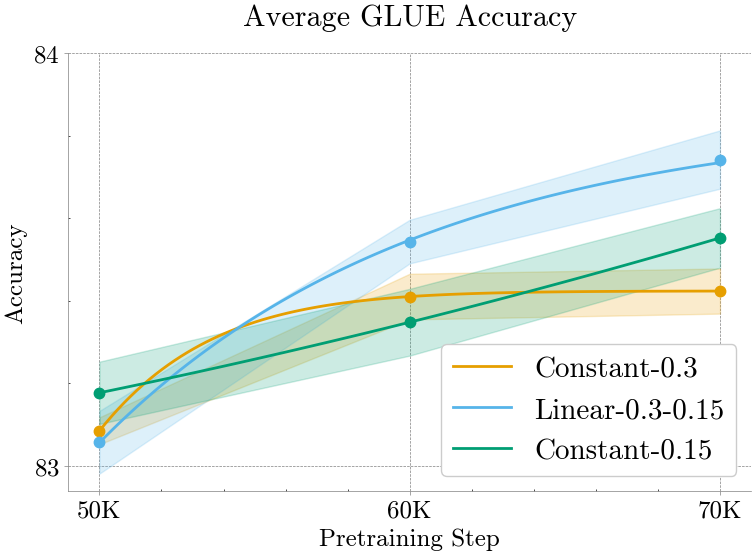

In [50]:
# run_bases = ["linear-0.3-0.15", "cosine-0.3-0.15", "step-0.3-0.15", "constant-0.3-0.3", "constant-0.15-0.15"]
run_bases = ["linear-0.3-0.15", "constant-0.3-0.3", "constant-0.15-0.15"]
plot_params = {"linear-0.3-0.15": {"color": C[0]},
               "constant-0.3-0.3": {"color": C[1]},
               "constant-0.15-0.15": {"color": C[2]}
              }
x_ticks = [*range(10_000, 70_001, 10_000)]
# plt.figure(figsize=(16,70))
plt.figure(figsize=(8,6))
# fig, 
# max_perf = 0
ax = plt.subplot(1, 1, 1)
#     ax.set_figheight(2)
#     ax.set_figwidth(2)
for run_idx, (run_base, run_info) in enumerate(speedup_results.items()):

    if "constant" in run_base:
        label = "-".join(run_base.split("-")[:2])
    else:
        label = run_base

    #x_ticks = [*range(10_000, 70_001, 10_000)]
    x_ticks = [50_000, 60_000, 70_000]
    xfit = np.linspace(run_info["x"][0], run_info["x"][-1], 100)
    label = string.capwords(label)
    ax.plot(x_ticks, run_info["y"], ".", color=C[run_idx], markersize=15,)
    # ax.plot(x_ticks, run_info["y"],  lw=2, color=C[run_idx], label=label)
    errs = err_df[err_df.experiment_name == run_base]["final_metric_ste"].values
    ax.fill_between(x_ticks, run_info["y"] - errs, run_info["y"] + errs, alpha=0.2, color=C[run_idx])
    # print(run_info["coefs"], "color")
    # print(x_ticks)
    ax.plot(xfit, func_family(xfit, *run_info["coefs"]), '-', lw=2, color=C[run_idx], label=label)
    # if max(perfs) > max_perf: max_perf = max(perfs)
ax.locator_params(axis='y', nbins=10)
ax.legend(loc="lower right")
title = string.capwords(task.replace("_", " "))
ax.set_title("Average GLUE Accuracy")
ax.set_xlabel("Pretraining Step")
ax.set_ylabel("Accuracy")
# plt.axhline(y=84.12, xmin=.05, xmax=.95, linestyle='dashed', color="black")
# plt.axhline(y=83.83, xmin=.05, xmax=.95, linestyle='dashed', color="black")
# plt.axvline(x=34_000, linestyle='-.', color="gray", label="Half Training Duration")
plt.yticks([*range(83, 85, 1)])
plt.ticklabel_format(axis="x", style="sci", useMathText=True)
plt.xticks(x_ticks, ["50K", "60K", "70K"])
format_axes(ax)
plt.tight_layout()
# plt.grid(which='major', axis='y', linestyle='')
# plt.grid(which='major', axis='x', linestyle='')
plt.savefig("plots/glue-curve-speedup.pdf")
# plt.show()